In [1]:
import sympy as sp

from math import pi, sin, cos, sqrt, tanh

from siltsong import cartesian_to_spherical, plot_density_powernorm, radiative_transfer
from siltsong.dust import mrn, thermal_emission, henyey_greenstein
from siltsong.stars import blackbody

In [2]:
view_length = 6e17
distance_steps = 200
theta_steps = 360
phi_steps = 360
distance_substeps = 10
dr = view_length / 2 / distance_steps
ds = dr / distance_substeps
dphi = pi / phi_steps

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 60
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

ms_count = 1e5

wavelength = 5.47e-5

grain_size_min = 5e-7
grain_size_max = 1e-4
exponent = -3.5
rho_gr = 3
sigma_rho_gr = 1.109

mdot = 10 * 4e-7 * 2e33 / (365 * 24 * 60 * 60)

rin = 2e14 # cm, Inner cavity radius - Default : 1e16
density_enhancement = 25 # Density enhancement factor in the lobe walls - Default : 10
eccentricity = 0.85 # Eccentricity of the conic region of the outer lobe function - Default : 0.72
eccentricity_2 = 0.8 # Eccentricity of the conic region of the inner lobe function - Default : 0.72
focus_shift = view_length * 0.004 # Coordinate of the conic section edge - Default : view_length * 0.01
focus_shift_2 = view_length * 0.002  # Coordinate of the inner conic section edge - Default : view_length * 0.03
focus = view_length * 0.027 - focus_shift # cm, Location of the focus of the conic shaped lobe - Default : -view_length / 100
focus_2 = view_length * 0.027 - focus_shift_2 # cm, Location of the focus of the conic shaped lobe - Default : -view_length / 100
ansa_eccentricity = 0.55 # Eccentricity of the ansa - Default : 0.85
ansa_focus_shift = -view_length * 0.14 # Location of the base of the ansa - Default : -view_length * 0.11
ansa_focus = view_length * 0.01 - ansa_focus_shift # cm, Location of the ansa focus - Default : view_length / 4
ansa_directrix = -(ansa_focus + ansa_focus_shift) / ansa_eccentricity - ansa_focus_shift # cm, Location of the ansa directrix - Default : view_length / 4
cutoff_distance = view_length * 0.22 # 0.24 # cm, Cutoff from the conic region to the linear region in the lobes
cutoff_distance_2 = view_length * 0.21 # cm, Cutoff from the conic region to the linear region in the lobes
slope = 0.36 # 0.24 # dimensionless, Slope of the linear region for the outer lobe function
slope_2 = 0.32 # dimensionless, Slope of the linear region for the inner lobe function
directrix = -(focus + focus_shift) / eccentricity - focus_shift # cm, Location of the directrix of the conic shaped lobe - Default : -view_length / 10.9ansa_eccentricity = 0.55 # Eccentricity of the ansa - Default : 0.85
directrix_2 = -(focus_2 + focus_shift_2) / eccentricity_2 - focus_shift_2

In [3]:
central_source = blackbody(wavelength, temperature = 20000)
    
sca_cm_squared_per_g, ext_cm_squared_per_g = mrn(grain_size_min, grain_size_max, exponent, rho_gr, sigma_rho_gr, wavelength)

sca_cm_squared_per_g, ext_cm_squared_per_g = mrn() # Alternatively use default parameters, identical to above

source_function = thermal_emission(wavelength, temperature = 10)

def scattering_phase_function(angle):
    return henyey_greenstein(angle, asymmetry_constant = 0.6)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scattering_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_sca_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A8 of Li et al. 2024
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to 

In [4]:
x, y = sp.symbols('x y')
eq1 = sp.Eq((eccentricity * (x - directrix)) * (eccentricity * (x - directrix)) - x * x - focus * focus + 2 * x * focus - y ** 2, 0) # Outer conic section formula
eq2 = sp.Eq((x + focus_shift) ** 2 + y ** 2 - cutoff_distance ** 2, 0) # The point distance to the center has to be equal to cutoff_distance
sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
x_cut = abs(sol[3][0]) # x coordinate of the point
y_cut = abs(sol[3][1]) # y coordinate of the point

x, y = sp.symbols('x y')
eq1 = sp.Eq((eccentricity_2 * (x - directrix_2)) * (eccentricity_2 * (x - directrix_2)) - x * x - focus_2 * focus_2 + 2 * x * focus_2 - y ** 2, 0) # Inner conic section formula
eq2 = sp.Eq((x + focus_shift_2) ** 2 + y ** 2 - cutoff_distance_2 ** 2, 0) # The point distance to the center has to be equal to cutoff_distance_2
sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
x_cut_2 = abs(sol[3][0]) # x coordinate of the point
y_cut_2 = abs(sol[3][1]) # y coordinate of the point

y_intercept = y_cut + slope * x_cut # Calculates the y-intercept of the outer linear boundary
y_intercept_2 = y_cut_2 + slope_2 * x_cut_2 # y_cut_2 + slope * x_cut_2 # Calculates the y-intercept of the inner linear boundary

def lobe(x):
    x = abs(x)
    y_2_squared = (eccentricity_2 * (x - directrix_2)) * (eccentricity_2 * (x - directrix_2)) - x * x - focus_2 * focus_2 + 2 * x * focus_2
    y_2 = sqrt(y_2_squared * (y_2_squared >= 0))
    y_squared = (eccentricity * (x - directrix)) * (eccentricity * (x - directrix)) - x * x - focus * focus + 2 * x * focus
    y = sqrt(y_squared * (y_squared >= 0))
    y_2_alt = y_intercept_2 - x * slope_2
    y_alt = y_intercept - x * slope
    if x > x_cut_2:
        return (y_2_alt, y_alt) if x > x_cut else (y_2_alt, y)
    return (y_2, y_alt) if x > x_cut else (y_2, y)

def ansa(x):
    
    x = abs(x)
    y_squared = (ansa_eccentricity * (x - ansa_directrix)) * (ansa_eccentricity * (x - ansa_directrix)) - x * x - ansa_focus * ansa_focus + 2 * x * ansa_focus
    
    return sqrt(y_squared * (y_squared >= 0))

def find_density(x, y, latitude, distance):
    
    if abs(latitude) >= 85 / 180 * pi and distance > 3e17:
        
        velocity = 7.5e7

        mass_density = mdot / (4 * pi * (distance * distance) * velocity)
        
        return mass_density
    
    elif distance >= 2.5e17:
        
        return 0
    
    sin_lat = abs(x / distance)
    sin_lat_squared = sin_lat * sin_lat
    cos_lat_squared = 1 - sin_lat_squared
    
    if y < ansa(x):
        
        velocity = 1e6

        mass_density = mdot / (16 * pi * 1e34 * velocity)
        
        return mass_density
    
    y_low, y_high = lobe(x)
    
    if distance < rin * 2: 
        
        cutoff_inner = 0.5 * (1 - tanh((rin - distance) / (rin / 10)))
        
    else: 
        
        cutoff_inner = 1
    
    if y <= y_high: 
        
        cutoff_outer = 0.5 * (1 - tanh((distance - 1.8e17) / 1e16))
        
        if y <= y_low: 
            
            velocity = 5e7
            
            area = pi * y_low * y_low

            mass_density = cutoff_outer * cutoff_inner * mdot / (16 * area * velocity)
            
            return mass_density
        
        velocity = 4e7 / density_enhancement / (distance * distance / 1e34)
        
        mass_density = cutoff_outer * mdot / (4 * pi * (distance * distance) * velocity)
        
        return mass_density
    
    else: 
        
        R_cur = 1e17
        dr_cur = 2e15
        velocity = 1e6

    cutoff_outer = 0.5 * (1 - tanh((distance - R_cur) / dr_cur))

    mass_density = mdot * (cutoff_outer * cutoff_inner) / (4 * pi * distance * distance * velocity)
    
    return mass_density

def density_spherical(r, theta):

    latitude = pi / 2 - theta
    if r < rin / 2:

        return 0
    
    x = r * sin(latitude)
    y = sqrt(r * r - x * x)
    
    return find_density(x, y, latitude, r)

def density_cartesian(x, y, z):
    
    spherical = cartesian_to_spherical(x, y, z)
    latitude, distance = pi / 2 - spherical[1], spherical[0]
    
    if distance < rin / 2:
        
        return 0
    
    y = sqrt(x ** 2 + y ** 2)
    x = z
    return find_density(x, y, latitude, distance)

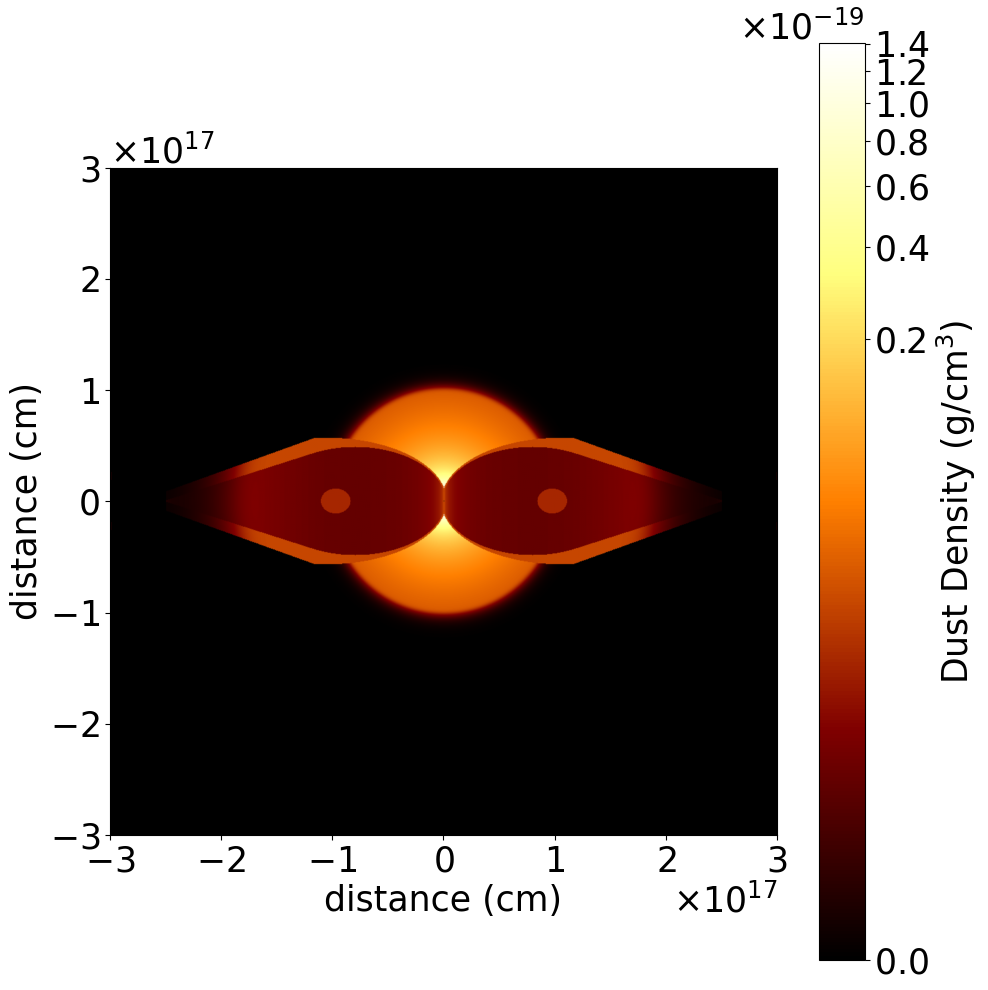

In [5]:
plot_density_powernorm(density_cartesian, view_length, power = 0.2)

In [6]:
image = radiative_transfer(view_length, inclination_degrees, resolution, 
                           central_source, 
                           density_spherical, density_cartesian, 
                           sca_cm_squared_per_g, ext_cm_squared_per_g, source_function, scattering_phase_function, 
                           depth, depth_substeps, distance_steps, distance_substeps, theta_steps, phi_steps, 
                           ms_count)

Sending isotropic photons from central star(s): 


 45%|██████████████████▎                      | 161/360 [04:59<05:18,  1.60s/it]Exception ignored in: <function ResourceTracker.__del__ at 0x1055593a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1076593a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _

Tracing multiple scattered photons: 


100%|██████████████████████████████████| 100000/100000 [06:42<00:00, 248.21it/s]


Performing peel-off: 


100%|█████████████████████████████████████████| 201/201 [03:04<00:00,  1.09it/s]


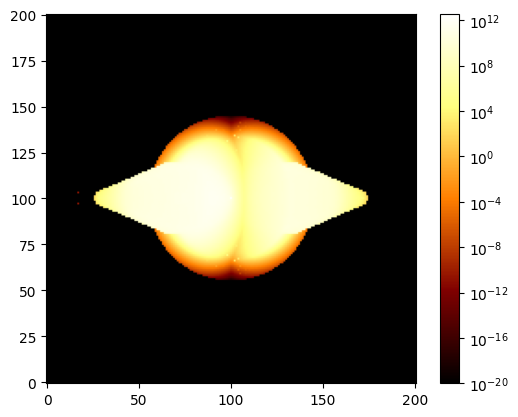

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

buffer = 1e-20 # np.min(image[image > 0])
buffered_image = image.copy()
buffered_image[buffered_image <= buffer] = buffer

plt.imshow(buffered_image, origin = 'lower', cmap = 'afmhot', norm = LogNorm())
plt.colorbar()
plt.show()

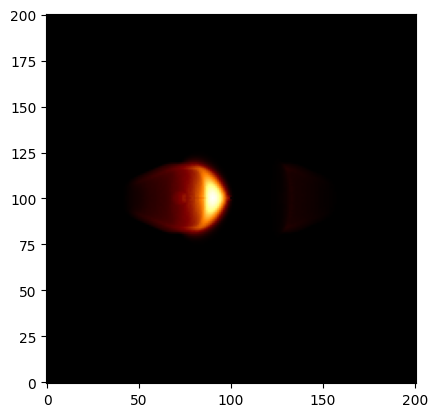

In [8]:
image_star_removed = image.copy()
image_star_removed[100, 100] = 0
plt.imshow(image_star_removed, origin = 'lower', cmap = 'afmhot')

In [9]:
# END